### Part 1: BUSINESS UNDERSTANDING
#### Question 1: What is the correlation of the different features with the cost?
#### Question 2: Does the correlation vary by region and business unit?
#### Question 3: What are main clusters to which the invidual records [SKUs] can be assigned?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import hdbscan
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model


2023-03-19 20:06:11.286106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-03-19 20:06:11.286152: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### PART 2: DATA UNDERSTANDING
#### a] The input dataframe contains SKU [Stock Keeping Unit] data for a particular commodity
#### b] There are 648 rows and 28 feature columns
#### c] Of the 28 feature columns, 21 are numeric and 5 are alpha-numeric
#### d] The numeric features [excluding Attr3_Costamount_norm] describe technical aspects of the SKU
#### Data pre-processing:
##### The raw input features have been processed based on their distribution. Due to the confidentiality of the raw data, it has not shown in this notebook
##### The features of the raw data have been processed as follows:
##### a] If the feature has normal distribution, then the feature has been normalized -- (X - mean)/std
##### b] If the feature did not follow a normal distribution, then a 2 step process was applied. 1] The feature value was replaced with their respective quantiles 2] Min-max scaling was applied to the quantiles
##### c] If the feature was categorical, then one-hot encoding was used

In [2]:
# Read in the data
# Main change from v2 to v3 is that the specific regions have been replaced with general regions
cmd_data = pd.read_csv('/data2/home/prasannaiyer/Projects/SKU_Cluster_Local/SKU_Clusters/Data/cmd_attributes_v3_upload.csv',\
    encoding = 'latin-1', decimal = '.', thousands = ',')

In [3]:
cmd_data.shape

(648, 28)

In [4]:
cmd_data.dtypes.value_counts()

int64      16
object      7
float64     5
dtype: int64

In [5]:
# Replace the values in p_bu: {'AW': 'AG', 'CW': 'CE'}
cmd_data['p_bu'] = cmd_data['p_bu'].replace({'AW': 'AG', 'CW': 'CE'})

In [6]:
total_skus = cmd_data.shape[0]

### EXPLORATORY DATA ANALYSIS

#### REVIEW CORRELATION
####    Focusing on Attr3_Costamount_norm (overall):
#### a] Attr4 and Attr5 have the highest correlation with cost. This is intuitive as the Attr4 and Attr5 describe the geometry of the commodity SKU and therefore majorly influence the cost
#### b] Attr1 and Attr9 also show meaningful correlation with cost. Attr1 partially reflects the geometry. Attr9 indicates a special welding requirement and therefore the impact on cost is as expected
#### Other observations
#### e] Attr9 shows meaningful correlation with Attr4 and Attr5. This indicates that enhanced geometry influences the need for the special welding requirement

NEXT STEP: Review the differences in correlation by region

Text(0.5, 1.0, 'Correlation Matrix of Commodity Data')

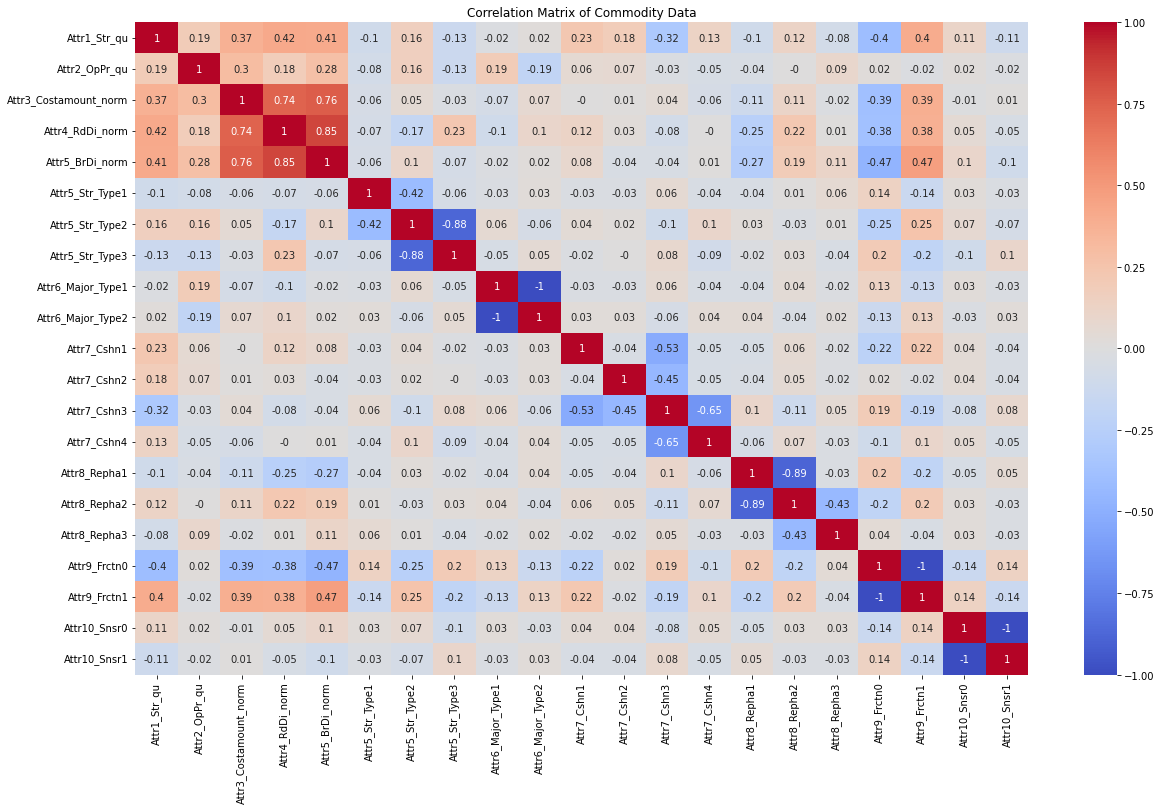

In [7]:
# Plot the correlation matrix
fig = plt.figure(figsize = (20, 12))
corr = cmd_data.corr()
#set the precision in corr dataframe to 2
corr = corr.round(2)
ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm')
ax.set_title('Correlation Matrix of Commodity Data')
#plt.xticks(rotation = 45)

Text(0.5, 1.0, 'Correlation Matrix of Commodity Data - Specific Attributes')

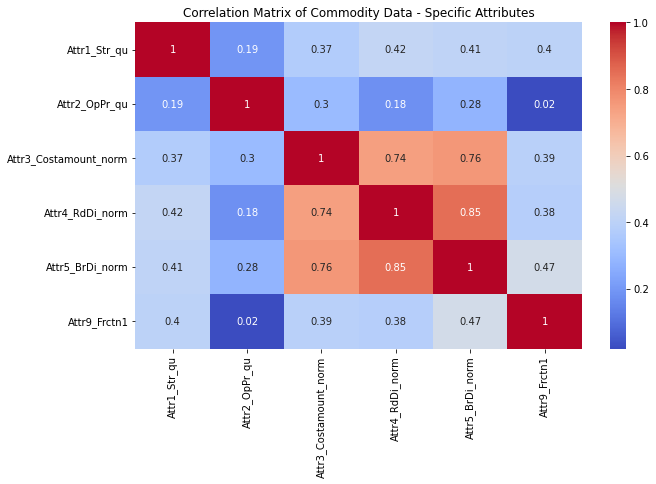

In [8]:
#Attributes for correlation matrix
corr_attributes = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm', 'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn1']
# show the correlation matrix for corr_attributes
fig = plt.figure(figsize = (10, 6))
corr = cmd_data[corr_attributes].corr().abs()
#set the precision in corr dataframe to 2
corr = corr.round(2)
ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm')
ax.set_title('Correlation Matrix of Commodity Data - Specific Attributes')

#### REVIEW CORRELATIONS BY REGION   
#### Focusing on Attr3_Costamount_norm (by region): Attribute with highest correlation with Attr3_Costamount_norm varies by region
#### a] Region 1: Attr5_BrDi_Norm [related to SKU geometry] 
#### b] Region 2: Attr1_Str_qu
#### c] Region 3: Attr5_BrDi_norm [related to SKU geometry]
#### d] Region 4: Attr5_RdDi_norm [related to SKU geometry]

#### NEXT STEP: Review correlation by p_bu (business unit) AND Review correlation for Region_2 by p_bu

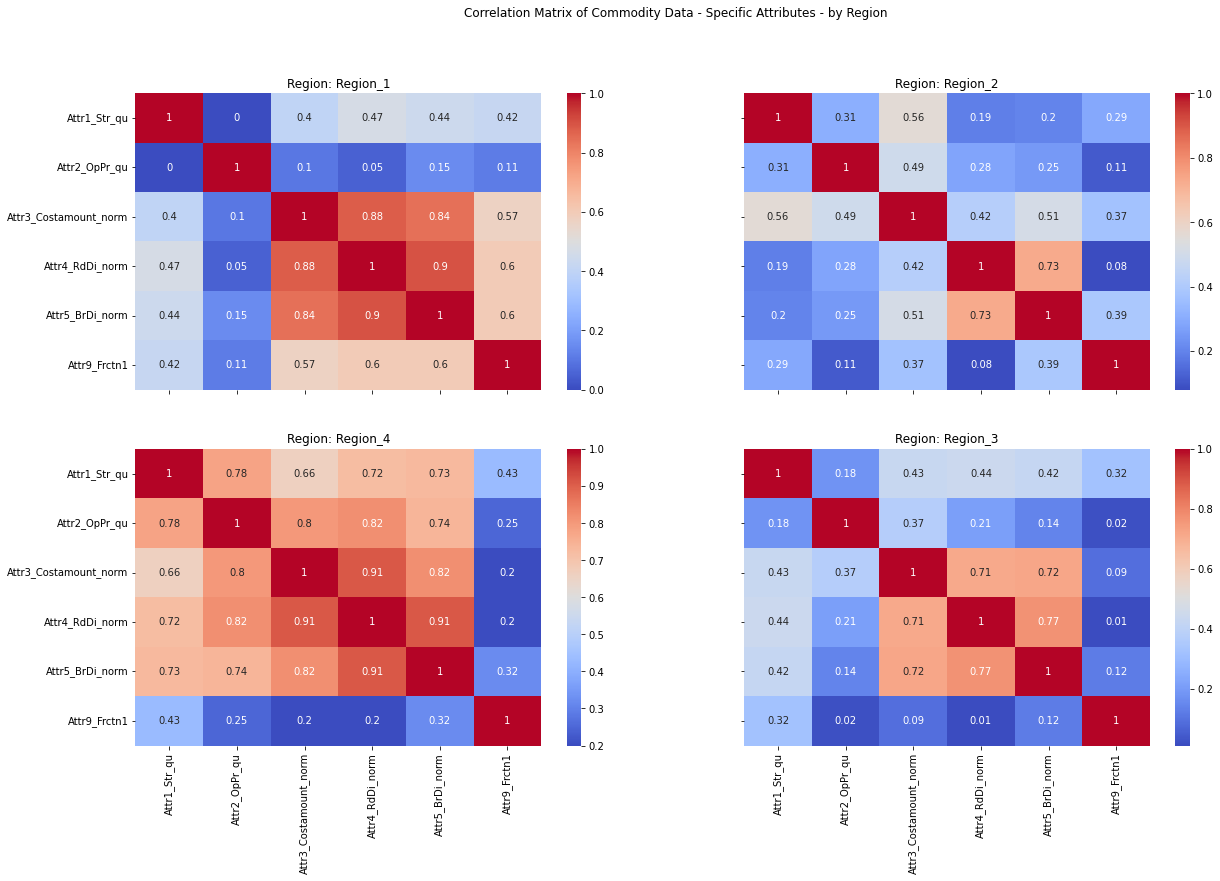

In [9]:
# plot a grid showing the correlation matrix for the different p_region values in cmd_data
# share the same x-axis and y-axis
fig, axes = plt.subplots(2, 2, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Correlation Matrix of Commodity Data - Specific Attributes - by Region')
for i, p_region in enumerate(cmd_data['p_region'].unique()):
    corr = cmd_data[cmd_data['p_region'] == p_region][corr_attributes].corr().abs()
    #set the precision in corr dataframe to 2
    corr = corr.round(2)
    ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = axes[i // 2, i % 2])
    ax.set_title('Region: ' + p_region)

#### REVIEW CORRELATION BY p_bU (BUSINESS UNIT)
#### While focusing on Attr3_Costamount_norm correlations among the main P_BU values:
##### For p_bu = 'AG', Attr4 & Attr5 have the most correlation with Attr3_Costamount_norm, followed by Attr9 & Attr1
##### For p_bu = 'CE', Attr4 & Attr5 have the most correlation with Attr3_Costamount_norm [correlation values are greater than p_bu = 'AG'], followed by Attr2. Attr9 does not show much variation for p_bu = 'CE' and therefore, the lack of strong correlation with Attr3_Costamount_norm is not surprising

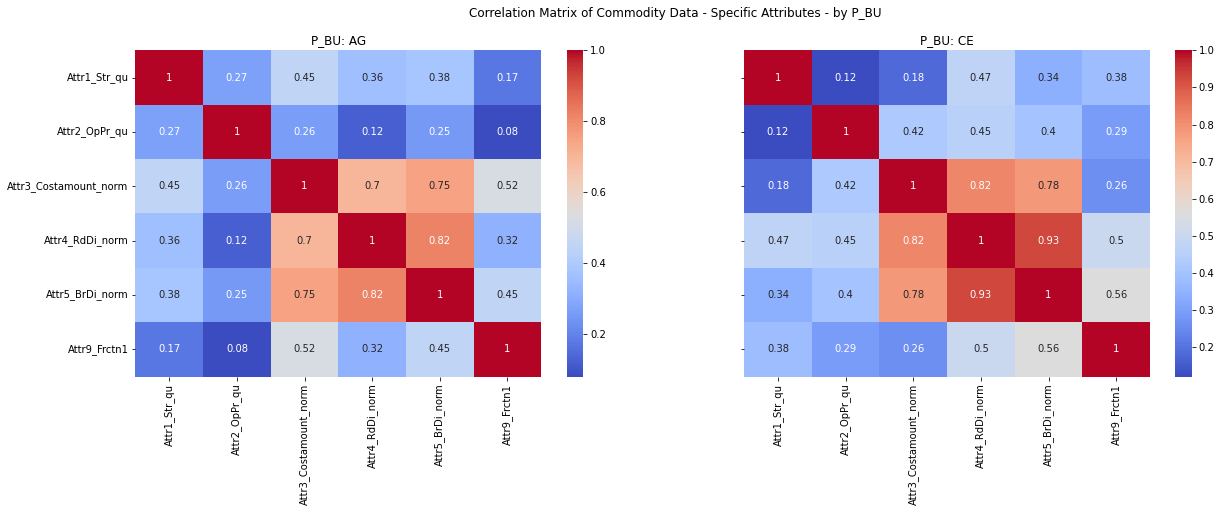

In [10]:
# Plot a grid showing the correlation matrix for the different p_bu values in cmd_data
# share the same x-axis and y-axis
fig, axes = plt.subplots(1, 2, figsize = (20, 6), sharex = True, sharey = True)
fig.suptitle('Correlation Matrix of Commodity Data - Specific Attributes - by P_BU')
for i, p_bu in enumerate(['AG', 'CE']):
    corr = cmd_data[cmd_data['p_bu'] == p_bu][corr_attributes].corr().abs()
    #set the precision in corr dataframe to 2
    corr = corr.round(2)
    ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = axes[i])
    ax.set_title('P_BU: ' + p_bu)

#### REVIEW CORRELATION FOR REGION_2 BY p_bu
#### Measurement of correlation by p_bu for Region_2
#### For p_bu = 'AG', Attr1_Str_qu has the highest correlation with Attr3_Costamount_norm
#### The observation on correlation is significantly different for p_bu = 'CE'. Attr2_OpPr_Qu, Attr4_RdDi and Attr5_BrDi are significantly correlated with the Attr3_Costamount_norm

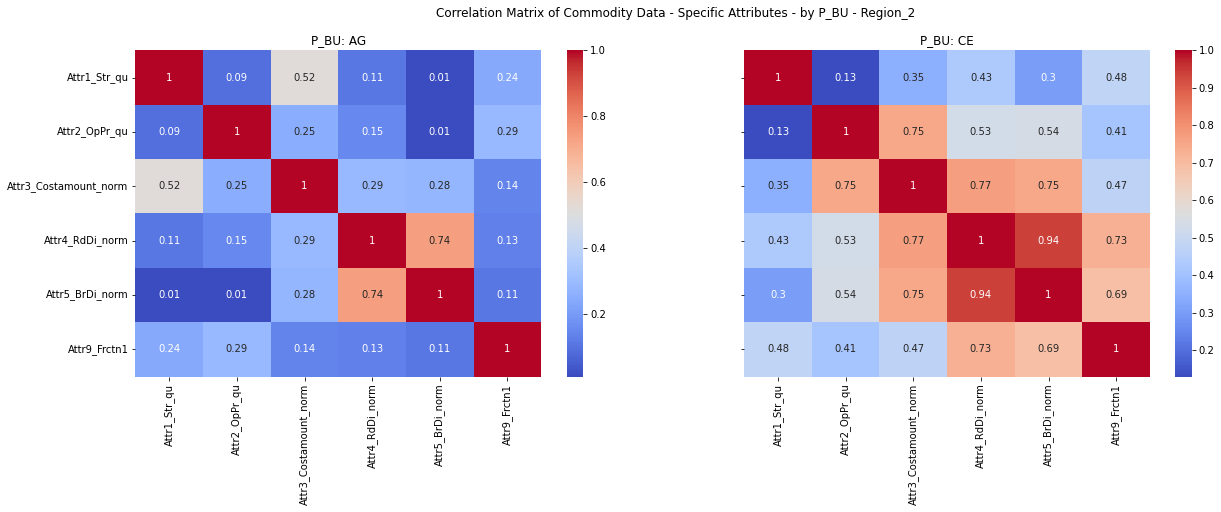

In [11]:
# plot the correlation plot for p_region = 'Region_2' for each p_bu
fig, axes = plt.subplots(1, 2, figsize = (20, 6), sharex = True, sharey = True)
fig.suptitle('Correlation Matrix of Commodity Data - Specific Attributes - by P_BU - Region_2')
for i, p_bu in enumerate(['AG', 'CE']):
    corr = cmd_data[(cmd_data['p_region'] == 'Region_2') & (cmd_data['p_bu'] == p_bu)][corr_attributes].corr().abs()
    #set the precision in corr dataframe to 2
    corr = corr.round(2)
    ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = axes[i])
    ax.set_title('P_BU: ' + p_bu) 



#### REVIEW Attr9_Frctn1 [special welding requirement] FOR EACH p_bu
#### p_bu = 'CE' has the highest sum of Attr9_Frctn1 [special welding requirement]. 76% of SKUs with p_bu = 'CE' have Attr9_Frct1 = 1

[Text(0, 3, '56 (9%)'), Text(0, 3, '128 (20%)'), Text(0, 3, '78 (12%)')]

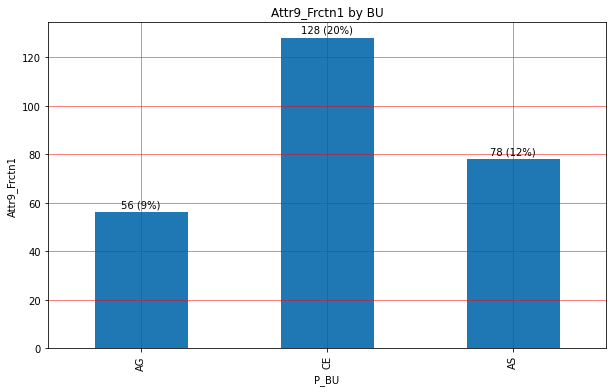

In [12]:
ax = cmd_data.groupby(by = 'p_bu')['Attr9_Frctn1'].sum().loc[['AG', 'CE', 'AS']].plot(kind = 'bar', figsize = (10, 6), title = 'Attr9_Frctn1 by BU')
ax.set_ylabel('Attr9_Frctn1')
ax.set_xlabel('P_BU')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:.0f} ({(x/total_skus)*100:,.0f}%)' for x in ax.containers[0].datavalues], padding = 3)



### REVIEW OF Attr1_Str_qu FOR EACH p_bu
#### From the KDE plot, it can be observed that the variance for Attr1_Str_qu is greater for AG compared to CE
#### This is also reflected in the variance coefficient. The variance coefficient for AG is 81% greater than CE -- AG = 0.69, CE = 0.38

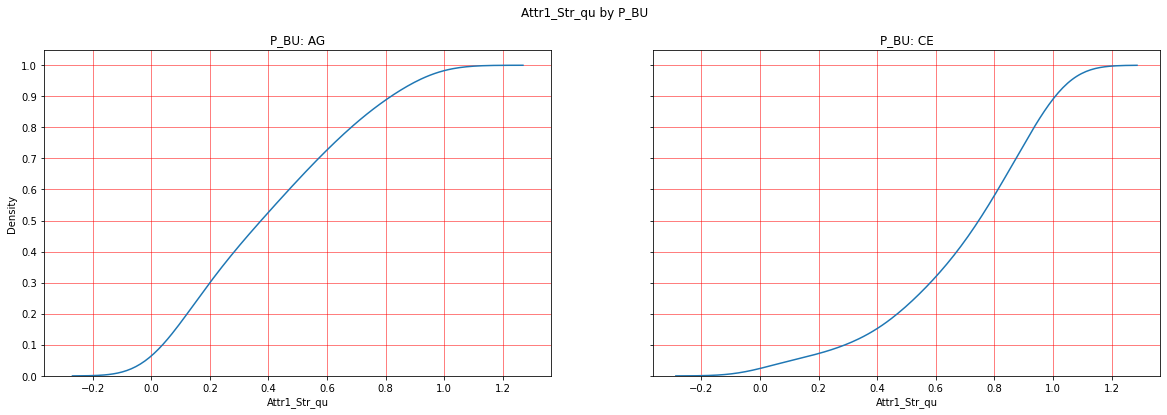

In [13]:
# create a seaborn kdeplot for Attr1_Str_qu for each p_bu
fig, axes = plt.subplots(1, 2, figsize = (20, 6), sharex = True, sharey = True)
fig.suptitle('Attr1_Str_qu by P_BU')
for i, p_bu in enumerate(['AG', 'CE']):
    ax = sns.kdeplot(data = cmd_data[cmd_data['p_bu'] == p_bu], x = 'Attr1_Str_qu', ax = axes[i], cumulative = True)
    ax.set_title('P_BU: ' + p_bu)
    ax.set_xlabel('Attr1_Str_qu')
    ax.set_ylabel('Density')
    ax.grid(linestyle='-', linewidth='0.5', color='red')
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))


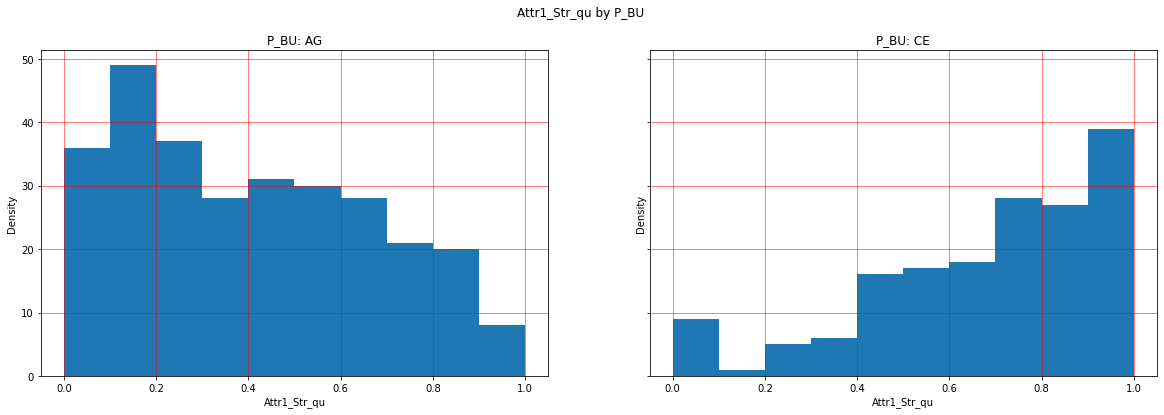

In [14]:
# create a histogram for Attr1_Str_qu for each p_bu
fig, axes = plt.subplots(1, 2, figsize = (20, 6), sharex = True, sharey = True)
fig.suptitle('Attr1_Str_qu by P_BU')
for i, p_bu in enumerate(['AG', 'CE']):
    ax = cmd_data[cmd_data['p_bu'] == p_bu]['Attr1_Str_qu'].hist(ax = axes[i], bins = 10, cumulative = False, linewidth = 2)
    ax.set_title('P_BU: ' + p_bu)
    ax.set_xlabel('Attr1_Str_qu')
    ax.set_ylabel('Density')
    ax.grid(linestyle='-', linewidth='0.5', color='red')

In [15]:
print(f'Variation Coefficient for Attr1_Str_qu - Overall: {cmd_data["Attr1_Str_qu"].std()/cmd_data["Attr1_Str_qu"].mean():.2f}')
print(f'Variation Coefficient for Attr1_Str_qu - AG: {cmd_data[cmd_data["p_bu"] == "AG"]["Attr1_Str_qu"].std()/cmd_data[cmd_data["p_bu"] == "AG"]["Attr1_Str_qu"].mean():.2f}')
print(f'Variation Coefficient for Attr1_Str_qu - CE: {cmd_data[cmd_data["p_bu"] == "CE"]["Attr1_Str_qu"].std()/cmd_data[cmd_data["p_bu"] == "CE"]["Attr1_Str_qu"].mean():.2f}')

Variation Coefficient for Attr1_Str_qu - Overall: 0.62
Variation Coefficient for Attr1_Str_qu - AG: 0.69
Variation Coefficient for Attr1_Str_qu - CE: 0.38


### REVIEW OF Attr2_OpPr_qu FOR EACH p_bu
#### From the KDE plot, it can be observed that the variance for Attr2_OpPr_qu is greater for AG compared to CE
#### This is also reflected in the variance coefficient. The variance coefficient for AG is 41% greater than CE -- AG = 0.65, CE = 0.46

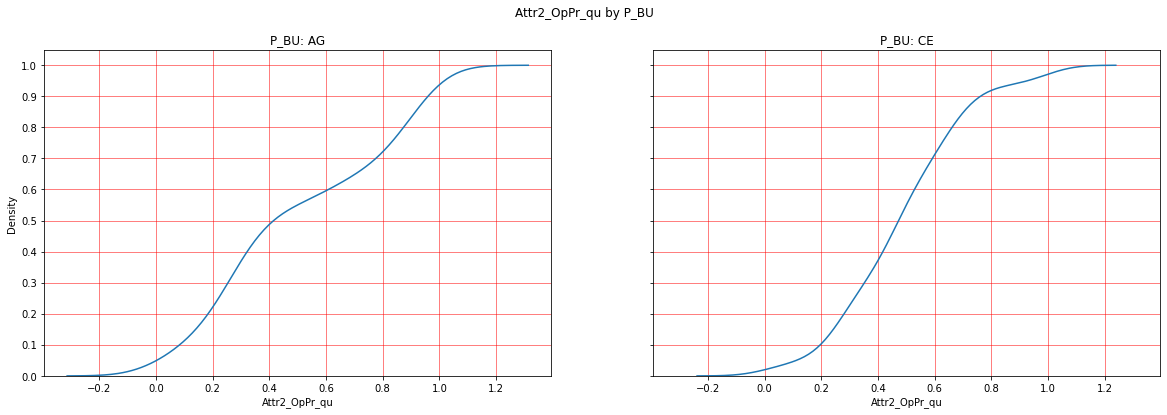

In [16]:
# create a seaborn kdeplot for Attr2_OpPr_qu for each p_bu
fig, axes = plt.subplots(1, 2, figsize = (20, 6), sharex = True, sharey = True)
fig.suptitle('Attr2_OpPr_qu by P_BU')
for i, p_bu in enumerate(['AG', 'CE']):
    ax = sns.kdeplot(data = cmd_data[cmd_data['p_bu'] == p_bu], x = 'Attr2_OpPr_qu', ax = axes[i], cumulative = True)
    ax.set_title('P_BU: ' + p_bu)
    ax.set_xlabel('Attr2_OpPr_qu')
    ax.set_ylabel('Density')
    ax.grid(linestyle='-', linewidth='0.5', color='red')
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

In [17]:
print(f'Variation Coefficient for Attr2_OpPr_qu - Overall: {cmd_data["Attr2_OpPr_qu"].std()/cmd_data["Attr2_OpPr_qu"].mean():.2f}')
print(f'Variation Coefficient for Attr2_OpPr_qu - AG: {cmd_data[cmd_data["p_bu"] == "AG"]["Attr2_OpPr_qu"].std()/cmd_data[cmd_data["p_bu"] == "AG"]["Attr2_OpPr_qu"].mean():.2f}')
print(f'Variation Coefficient for Attr2_OpPr_qu - CE: {cmd_data[cmd_data["p_bu"] == "CE"]["Attr2_OpPr_qu"].std()/cmd_data[cmd_data["p_bu"] == "CE"]["Attr2_OpPr_qu"].mean():.2f}')

Variation Coefficient for Attr2_OpPr_qu - Overall: 0.62
Variation Coefficient for Attr2_OpPr_qu - AG: 0.65
Variation Coefficient for Attr2_OpPr_qu - CE: 0.46


In [18]:
sku_attributes = ['Attr1_Str_qu', 'Attr2_OpPr_qu',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr7_Cshn1', 'Attr7_Cshn2', 'Attr7_Cshn3',
       'Attr7_Cshn4', 'Attr8_Repha1', 'Attr8_Repha2', 'Attr8_Repha3',
       'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1',
       'partnumber']

In [19]:
cmd_sku_data = cmd_data.groupby(by = sku_attributes)['Attr3_Costamount_norm'].mean().reset_index()

### REVIEW NUMBER OF SKUs BY REGION
#### Region_1 has the most number of SKUs at 48% of total, followed by Region_2 at 31% of total

[Text(0, 0, '311 (48%)'),
 Text(0, 0, '201 (31%)'),
 Text(0, 0, '84 (13%)'),
 Text(0, 0, '52 (8%)')]

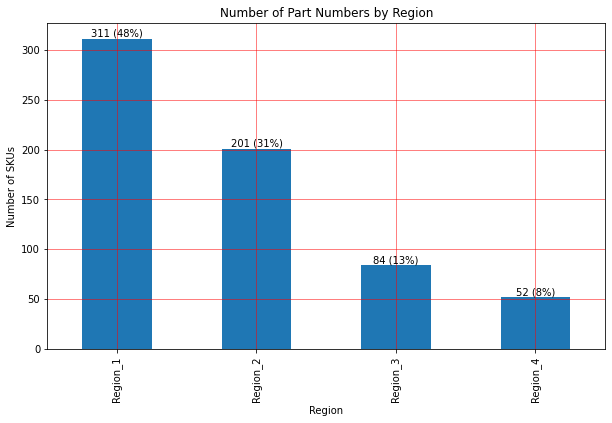

In [20]:
ax = cmd_data.groupby(by = 'p_region')['partnumber'].count().plot(kind = 'bar', title = 'Number of Part Numbers by Region', figsize = (10, 6))
ax.set_xlabel('Region')
ax.set_ylabel('Number of SKUs')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:,.0f} ({(x/total_skus)*100:,.0f}%)' for x in ax.containers[0].datavalues])


### REVIEW NUMBER OF SKUs BY p_bu
#### p_bu = 'AG' has the most number of SKUs at 44% of total, followed by p_bu = 'AS' at 30%

[Text(0, 0, '288 (44%)'), Text(0, 0, '194 (30%)'), Text(0, 0, '166 (26%)')]

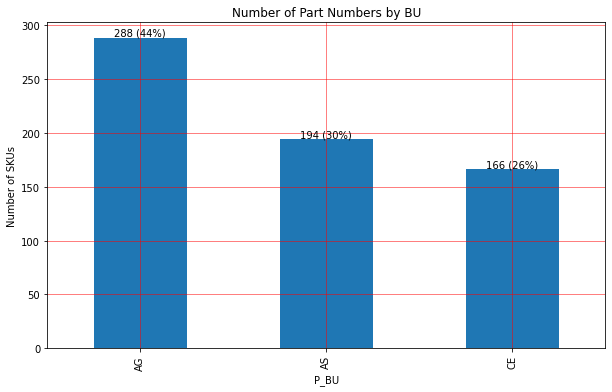

In [21]:
ax = cmd_data.groupby(by = 'p_bu')['partnumber'].count().plot(kind = 'bar', title = 'Number of Part Numbers by BU', figsize = (10, 6))
ax.set_xlabel('P_BU')
ax.set_ylabel('Number of SKUs')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:,.0f} ({(x/total_skus)*100:,.0f}%)' for x in ax.containers[0].datavalues])

[Text(0, 0, '0.34'),
 Text(0, 0, '-0.38'),
 Text(0, 0, '-0.11'),
 Text(0, 0, '-0.34')]

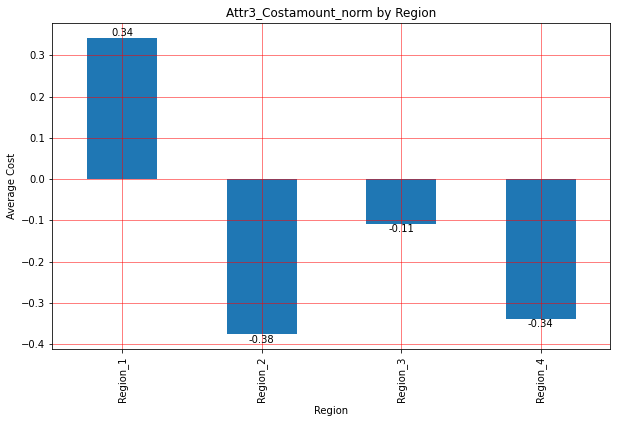

In [22]:
# Plot the average attr3_costamount_norm by region
ax = cmd_data.groupby(by = 'p_region')['Attr3_Costamount_norm'].mean().plot(kind = 'bar', title = 'Attr3_Costamount_norm by Region', figsize = (10, 6))
ax.set_xlabel('Region')
ax.set_ylabel('Average Cost')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:,.02f}' for x in ax.containers[0].datavalues])

### PART 3: DATA PREPARATION
#### Prepare the data for clustering

In [23]:
attr_for_clustering = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']

In [24]:
#create kmeans object
cluster1_kmeans = KMeans(n_clusters = 6, random_state = 42, max_iter = 250)
#fit kmeans object to data and get cluster labels
cluster1_kmeans.fit(cmd_data[attr_for_clustering])
#save new clusters for chart
cluster1_kmeans_labels = cluster1_kmeans.fit_predict(cmd_data[attr_for_clustering])

In [25]:
cmd_data['kmeans_labels'] = cluster1_kmeans_labels

In [26]:
# create clusters using hdbscan
cluster2_hdbscan = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 10, gen_min_span_tree = True)
cluster2_hdbscan_labels = cluster2_hdbscan.fit_predict(cmd_data[attr_for_clustering])
cmd_data['hdbscan_labels'] = cluster2_hdbscan_labels

In [27]:
attr_for_clustering_ae = ['Attr1_Str_qu', 'Attr2_OpPr_qu',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']

In [72]:
input_size = cmd_data[attr_for_clustering_ae].shape[1]
encoder_input = Input(shape = (input_size, ))
#encoder layer 1
encoder_l1 = Dense(input_size*2)(encoder_input)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = LeakyReLU()(encoder_l1)
#encoder layer 2
encoder_l2 = Dense(input_size)(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = LeakyReLU()(encoder_l2)
#encoder layer 3
encoder_l3 = Dense(float(input_size)/2.0)(encoder_l2)
encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = LeakyReLU()(encoder_l3)
#encoder bottleneck layer
encoder_output = Dense(8)(encoder_l3)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = LeakyReLU()(encoder_output)
#decoder layer 1
decoder_l1 = Dense(float(input_size)/2.0)(encoder_output)
decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = LeakyReLU()(decoder_l1)
#decoder layer 2
decoder_l2 = Dense(input_size)(decoder_l1)
decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = LeakyReLU()(decoder_l2)
# decoder layer 3
decoder_l3 = Dense(input_size*2)(decoder_l2)
decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = LeakyReLU()(decoder_l3)
#decoder output layer
#decoder_output = Dense(1, activation = 'linear')(decoder_l3)
decoder_output = Dense(input_size, activation = 'linear')(decoder_l3)
#define the autoencoder model
ae_2input = Model(encoder_input, decoder_output)
#compile the model
ae_2input.compile(optimizer = 'adam', loss = 'mse')

In [73]:
# fit the model
#ae_2input_cost_hist = ae_2input_cost.fit(cmd_data[attr_for_clustering_ae], cmd_data['Attr3_Costamount_norm'], epochs = 600, batch_size = 16, shuffle = True)
ae_2input_hist = ae_2input.fit(cmd_data[attr_for_clustering_ae], cmd_data[attr_for_clustering_ae], epochs = 3500, batch_size = 16, shuffle = True)



Epoch 1/3500
41/41 [==============================] - 2s 3ms/step - loss: 0.9287
Epoch 2/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.4196
Epoch 3/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.2423
Epoch 4/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.1596
Epoch 5/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.1190
Epoch 6/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.1063
Epoch 7/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0991
Epoch 8/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0878
Epoch 9/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0871
Epoch 10/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0833
Epoch 11/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0798
Epoch 12/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 13/3500
41/41 [====

In [74]:
print(f'Model Loss: {ae_2input_hist.history["loss"][-1]:.4f}')
print(f'Model Loss - Epoch 50: {ae_2input_hist.history["loss"][50]:.4f}')
print(f'Model Loss - Epoch 500: {ae_2input_hist.history["loss"][500]:.4f}')
print(f'Model Loss - Epoch 1000: {ae_2input_hist.history["loss"][1000]:.4f}')
print(f'Model Loss - Epoch 1500: {ae_2input_hist.history["loss"][1500]:.4f}')
print(f'Model Loss - Epoch 2000: {ae_2input_hist.history["loss"][2000]:.4f}')
print(f'Model Loss - Epoch 2500: {ae_2input_hist.history["loss"][2500]:.4f}')
print(f'Model Loss - Epoch 3000: {ae_2input_hist.history["loss"][3000]:.4f}')
print(f'Model Loss - Epoch 3500: {ae_2input_hist.history["loss"][3499]:.4f}')
print(f'Minimum loss & epoch: {min(ae_2input_hist.history["loss"]):.4f} & {ae_2input_hist.history["loss"].index(min(ae_2input_hist.history["loss"]))}')

Model Loss: 0.0095
Model Loss - Epoch 50: 0.0532
Model Loss - Epoch 500: 0.0182
Model Loss - Epoch 1000: 0.0159
Model Loss - Epoch 1500: 0.0130
Model Loss - Epoch 2000: 0.0125
Model Loss - Epoch 2500: 0.0113
Model Loss - Epoch 3000: 0.0110
Model Loss - Epoch 3500: 0.0095
Minimum loss & epoch: 0.0073 & 3215


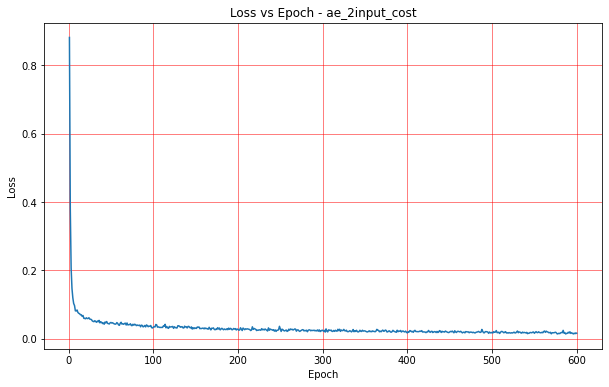

In [39]:
plt.figure(figsize = (10, 6))
ax = sns.lineplot(x = range(1, len(ae_2input_hist.history['loss'])+1), y = ae_2input_hist.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epoch - ae_2input')
ax.grid(linestyle='-', linewidth='0.5', color='red')


In [32]:
encoder_model = Model(encoder_input, encoder_output)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 26)                364       
_________________________________________________________________
batch_normalization (BatchNo (None, 26)                104       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                351       
_________________________________________________________________
batch_normalization_1 (Batch (None, 13)                52        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 13)                0   

In [33]:
encoded_cylinder_attributes = encoder_model.predict(cmd_data[attr_for_clustering_ae])
encoded_cylinder_attributes = pd.DataFrame(encoded_cylinder_attributes, columns = ['attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5', 'attr_6', 'attr_7', 'attr_8'])

### GENERARE EMBEDDINGS USING Attr3_CostAmount_norm as the output

In [40]:
input_size = cmd_data[attr_for_clustering_ae].shape[1]
encoder_input = Input(shape = (input_size, ))
#encoder layer 1
encoder_l1 = Dense(input_size*2)(encoder_input)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = LeakyReLU()(encoder_l1)
#encoder layer 2
encoder_l2 = Dense(input_size)(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = LeakyReLU()(encoder_l2)
#encoder layer 3
encoder_l3 = Dense(float(input_size)/2.0)(encoder_l2)
encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = LeakyReLU()(encoder_l3)
#encoder bottleneck layer
encoder_output = Dense(8)(encoder_l3)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = LeakyReLU()(encoder_output)
#decoder layer 1
decoder_l1 = Dense(float(input_size)/2.0)(encoder_output)
decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = LeakyReLU()(decoder_l1)
#decoder layer 2
decoder_l2 = Dense(input_size)(decoder_l1)
decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = LeakyReLU()(decoder_l2)
# decoder layer 3
decoder_l3 = Dense(input_size*2)(decoder_l2)
decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = LeakyReLU()(decoder_l3)
#decoder output layer
decoder_output = Dense(1, activation = 'linear')(decoder_l3)
#decoder_output = Dense(input_size, activation = 'linear')(decoder_l3)
#define the autoencoder model
ae_2input_cost = Model(encoder_input, decoder_output)
#compile the model
ae_2input_cost.compile(optimizer = 'adam', loss = 'mse')

In [67]:
ae_2input_cost_hist = ae_2input_cost.fit(cmd_data[attr_for_clustering_ae], cmd_data['Attr3_Costamount_norm'], epochs = 3500, batch_size = 16, shuffle = True)

Epoch 1/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 2/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 3/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 4/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 5/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 6/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 7/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0534
Epoch 8/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 9/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0673
Epoch 10/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 11/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 12/3500
41/41 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 13/3500
41/41 [====

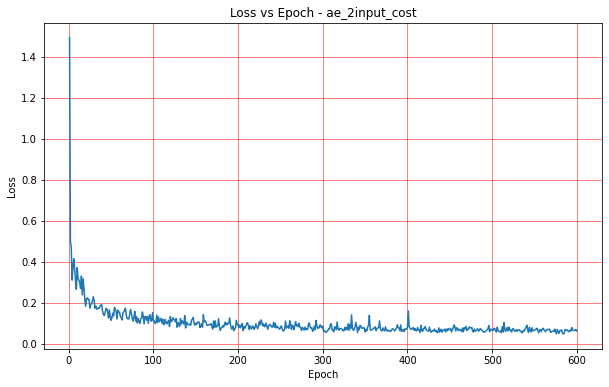

In [42]:
plt.figure(figsize = (10, 6))
ax = sns.lineplot(x = range(1, len(ae_2input_cost_hist.history['loss'])+1), y = ae_2input_cost_hist.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epoch - ae_2input_cost')
ax.grid(linestyle='-', linewidth='0.5', color='red')

### GENERATE EMBEDDINGS WITH ENTIRE INPUT AS OUTPUT AND NO BATCH NORM

In [68]:
input_size = cmd_data[attr_for_clustering_ae].shape[1]
encoder_input = Input(shape = (input_size, ))
#encoder layer 1
encoder_l1 = Dense(input_size*2)(encoder_input)
#encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = LeakyReLU()(encoder_l1)
#encoder layer 2
encoder_l2 = Dense(input_size)(encoder_l1)
#encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = LeakyReLU()(encoder_l2)
#encoder layer 3
encoder_l3 = Dense(float(input_size)/2.0)(encoder_l2)
#encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = LeakyReLU()(encoder_l3)
#encoder bottleneck layer
encoder_output = Dense(8)(encoder_l3)
#encoder_output = BatchNormalization()(encoder_output)
encoder_output = LeakyReLU()(encoder_output)
#decoder layer 1
decoder_l1 = Dense(float(input_size)/2.0)(encoder_output)
#decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = LeakyReLU()(decoder_l1)
#decoder layer 2
decoder_l2 = Dense(input_size)(decoder_l1)
#decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = LeakyReLU()(decoder_l2)
# decoder layer 3
decoder_l3 = Dense(input_size*2)(decoder_l2)
#decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = LeakyReLU()(decoder_l3)
#decoder output layer
#decoder_output = Dense(1, activation = 'linear')(decoder_l3)
decoder_output = Dense(input_size, activation = 'linear')(decoder_l3)
#define the autoencoder model
ae_2input1 = Model(encoder_input, decoder_output)
#compile the model
ae_2input1.compile(optimizer = 'adam', loss = 'mse')

In [69]:
ae_2input1_hist = ae_2input1.fit(cmd_data[attr_for_clustering_ae], cmd_data['Attr3_Costamount_norm'], epochs = 3500, batch_size = 16, shuffle = True)

Epoch 1/3500
41/41 [==============================] - 1s 2ms/step - loss: 0.8280
Epoch 2/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.3199
Epoch 3/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.1504
Epoch 4/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.1331
Epoch 5/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.1183
Epoch 6/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.1096
Epoch 7/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.1125
Epoch 8/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.1071
Epoch 9/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 10/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0919
Epoch 11/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0933
Epoch 12/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0905
Epoch 13/3500
41/41 [====

In [71]:
print(f'Model Loss - Epoch 50: {ae_2input1_hist.history["loss"][50]:.4f}')
print(f'Model Loss - Epoch 500: {ae_2input1_hist.history["loss"][500]:.4f}')
print(f'Model Loss - Epoch 1000: {ae_2input1_hist.history["loss"][1000]:.4f}')
print(f'Model Loss - Epoch 1500: {ae_2input1_hist.history["loss"][1500]:.4f}')
print(f'Model Loss - Epoch 2000: {ae_2input1_hist.history["loss"][2000]:.4f}')
print(f'Model Loss - Epoch 2500: {ae_2input1_hist.history["loss"][2500]:.4f}')
print(f'Model Loss - Epoch 3000: {ae_2input1_hist.history["loss"][3000]:.4f}')
print(f'Model Loss - Epoch 3500: {ae_2input1_hist.history["loss"][3499]:.4f}')
print(f'Minimum loss & epoch: {min(ae_2input1_hist.history["loss"]):.4f} & {ae_2input1_hist.history["loss"].index(min(ae_2input1_hist.history["loss"]))}')

Model Loss - Epoch 50: 0.0432
Model Loss - Epoch 500: 0.0116
Model Loss - Epoch 1000: 0.0086
Model Loss - Epoch 1500: 0.0061
Model Loss - Epoch 2000: 0.0063
Model Loss - Epoch 2500: 0.0032
Model Loss - Epoch 3000: 0.0033
Model Loss - Epoch 3500: 0.0032
Minimum loss & epoch: 0.0026 & 3392


### GENERATE EMBEDDINGS USING Attr3_CostAmount_Norm AND REMOVE BATCHNORM

In [43]:
input_size = cmd_data[attr_for_clustering_ae].shape[1]
encoder_input = Input(shape = (input_size, ))
#encoder layer 1
encoder_l1 = Dense(input_size*2)(encoder_input)
#encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = LeakyReLU()(encoder_l1)
#encoder layer 2
encoder_l2 = Dense(input_size)(encoder_l1)
#encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = LeakyReLU()(encoder_l2)
#encoder layer 3
encoder_l3 = Dense(float(input_size)/2.0)(encoder_l2)
#encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = LeakyReLU()(encoder_l3)
#encoder bottleneck layer
encoder_output = Dense(8)(encoder_l3)
#encoder_output = BatchNormalization()(encoder_output)
encoder_output = LeakyReLU()(encoder_output)
#decoder layer 1
decoder_l1 = Dense(float(input_size)/2.0)(encoder_output)
#decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = LeakyReLU()(decoder_l1)
#decoder layer 2
decoder_l2 = Dense(input_size)(decoder_l1)
#decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = LeakyReLU()(decoder_l2)
# decoder layer 3
decoder_l3 = Dense(input_size*2)(decoder_l2)
#decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = LeakyReLU()(decoder_l3)
#decoder output layer
decoder_output = Dense(1, activation = 'linear')(decoder_l3)
#decoder_output = Dense(input_size, activation = 'linear')(decoder_l3)
#define the autoencoder model
ae_2input_cost1 = Model(encoder_input, decoder_output)
#compile the model
ae_2input_cost1.compile(optimizer = 'adam', loss = 'mse')

In [61]:
ae_2input_cost1_hist = ae_2input_cost1.fit(cmd_data[attr_for_clustering_ae], cmd_data['Attr3_Costamount_norm'], epochs = 3500, batch_size = 16, shuffle = True)

Epoch 1/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 2/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 3/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 4/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 5/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 6/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 7/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 8/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 9/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 10/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 11/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 12/3500
41/41 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 13/3500
41/41 [====

In [64]:
print(f'Model Loss - Epoch 50: {ae_2input_cost1_hist.history["loss"][50]:.4f}')
print(f'Model Loss - Epoch 500: {ae_2input_cost1_hist.history["loss"][500]:.4f}')
print(f'Model Loss - Epoch 1000: {ae_2input_cost1_hist.history["loss"][1000]:.4f}')
print(f'Model Loss - Epoch 1500: {ae_2input_cost1_hist.history["loss"][1500]:.4f}')
print(f'Model Loss - Epoch 2000: {ae_2input_cost1_hist.history["loss"][2000]:.4f}')
print(f'Model Loss - Epoch 2500: {ae_2input_cost1_hist.history["loss"][2499]:.4f}')
print(f'Model Loss - Epoch 3000: {ae_2input_cost1_hist.history["loss"][2999]:.4f}')
print(f'Model Loss - Epoch 3500: {ae_2input_cost1_hist.history["loss"][3499]:.4f}')
print(f'Minimum loss & epoch: {min(ae_2input_cost1_hist.history["loss"]):.4f} & {ae_2input_cost1_hist.history["loss"].index(min(ae_2input_cost1_hist.history["loss"]))+1}')

Model Loss - Epoch 50: 0.0042
Model Loss - Epoch 500: 0.0028
Model Loss - Epoch 1000: 0.0076
Model Loss - Epoch 1500: 0.0029
Model Loss - Epoch 2000: 0.0047
Model Loss - Epoch 2500: 0.0022
Model Loss - Epoch 3000: 0.0026
Model Loss - Epoch 3500: 0.0023
Minimum loss & epoch: 0.0020 & 3050


In [66]:
cmd_data['Attr3_Costamount_norm'].describe()

count    648.000000
mean       0.006229
std        1.009502
min       -0.649188
25%       -0.506239
50%       -0.339895
75%        0.036498
max        5.350902
Name: Attr3_Costamount_norm, dtype: float64

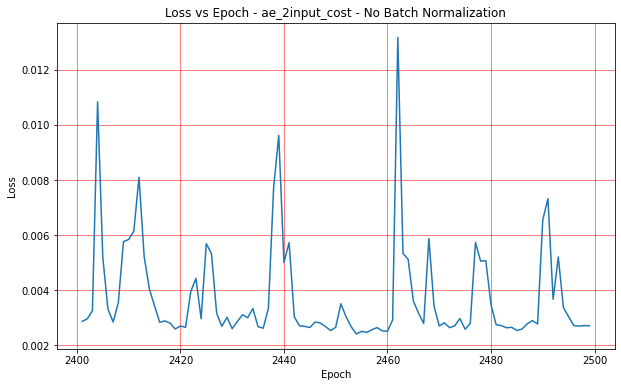

In [60]:
plt.figure(figsize = (10, 6))
#ax = sns.lineplot(x = range(1, len(ae_2input_cost1_hist.history['loss'])+1), y = ae_2input_cost1_hist.history['loss'])
ax = sns.lineplot(x = range(2401, len(ae_2input_cost1_hist.history['loss'])), y = ae_2input_cost1_hist.history['loss'][2400:2499])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epoch - ae_2input_cost - No Batch Normalization')
ax.grid(linestyle='-', linewidth='0.5', color='red')

In [34]:
cluster2_hdbscan = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 10, gen_min_span_tree = True)
cluster2_hdbscan_labels = cluster2_hdbscan.fit_predict(encoded_cylinder_attributes)
cmd_data['ae_labels'] = cluster2_hdbscan_labels

/data2/prasannaiyer/envs/AE_py335/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/data2/prasannaiyer/envs/AE_py335/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


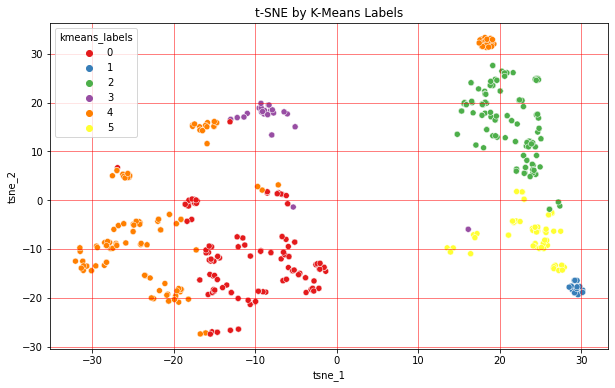

In [35]:
# plot t-sne and color by kmeans labels
tsne = TSNE(n_components = 2, perplexity = 30, random_state = 42)
tsne_results = tsne.fit_transform(cmd_data[attr_for_clustering])
cmd_data['tsne_1'] = tsne_results[:, 0]
cmd_data['tsne_2'] = tsne_results[:, 1]
# plot t-sne
fig, ax = plt.subplots(figsize = (10, 6))
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'kmeans_labels', data = cmd_data, ax = ax, palette = 'Set1')
ax.set_title('t-SNE by K-Means Labels')
ax.grid(linestyle='-', linewidth='0.5', color='red')


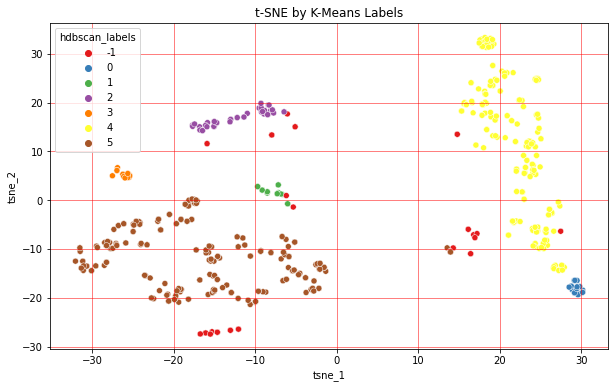

In [36]:
# plot t-sne and color by hdbscan labels
fig, ax = plt.subplots(figsize = (10, 6))
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'hdbscan_labels', data = cmd_data, ax = ax, palette = 'Set1')
ax.set_title('t-SNE by K-Means Labels')
ax.grid(linestyle='-', linewidth='0.5', color='red')

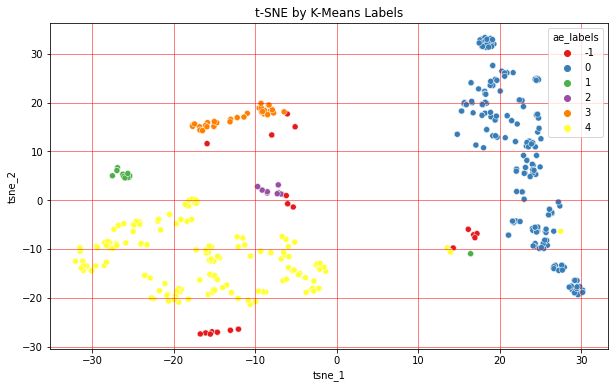

In [37]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'ae_labels', data = cmd_data, ax = ax, palette = 'Set1')
ax.set_title('t-SNE by K-Means Labels')
ax.grid(linestyle='-', linewidth='0.5', color='red')

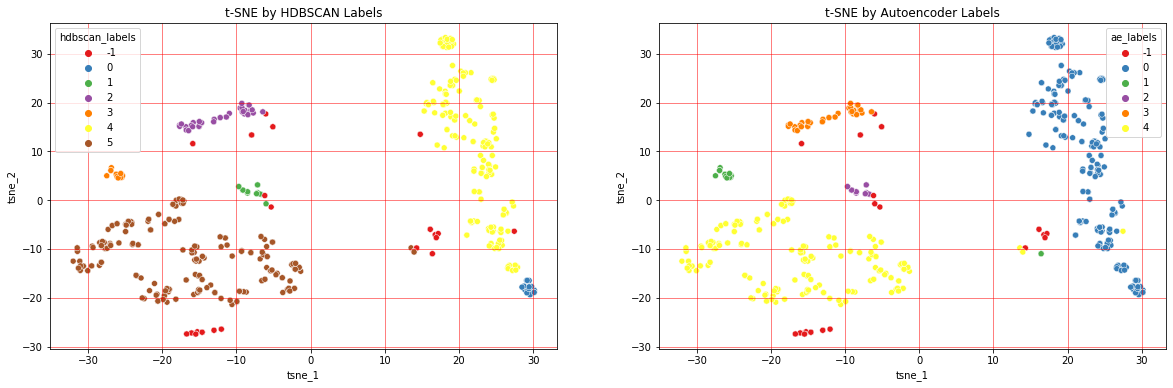

In [38]:
#plot the scatter plot for hdbscan labels and ae labels side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'hdbscan_labels', data = cmd_data, ax = ax1, palette = 'Set1')
ax1.set_title('t-SNE by HDBSCAN Labels')
ax1.grid(linestyle='-', linewidth='0.5', color='red')
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'ae_labels', data = cmd_data, ax = ax2, palette = 'Set1')
ax2.set_title('t-SNE by Autoencoder Labels')
ax2.grid(linestyle='-', linewidth='0.5', color='red')
